# Import

In [ ]:
!git init
!git pull https://github.com/terka2610/alz_det_ML.git

In [ ]:
!pip install PyWavelets
!pip install mne
!pip install optuna
!pip install torchviz
!pip install pyprep

In [ ]:
import numpy as np
import pandas as pd
import json
import os
import mne
import optuna


from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time # To measure time


import matplotlib.pyplot as plt

In [2]:
def read_json_dicts (file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data_dict = json.load(f)
    return pd.DataFrame(data_dict)

def collect_eeg_data(folder_path):
    data = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".set"):
            file_path = os.path.join(folder_path, filename)
            raw = mne.io.read_raw_eeglab(file_path, preload=True)
            data[filename] = raw.get_data()

    return data

## Model charya et al., 2025

In [3]:


class ConvNeXt1DBlock(nn.Module):
    def __init__(self, dim, drop_p=0.):
        super().__init__()
        # Depthwise convolution (applied independently to each channel)
        self.dwconv = nn.Conv1d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = nn.LayerNorm(dim, eps=1e-6) # LayerNorm applied on the channel dimension
        # Pointwise convolutions (expand and contract channels)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # Equivalent to 1x1 Conv for channel expansion
        self.act = nn.LeakyReLU(negative_slope=0.01)  # Change GELU to LeakyReLU
        self.pwconv2 = nn.Linear(4 * dim, dim) # Equivalent to 1x1 Conv for channel contraction
        self.drop_p = drop_p
        if self.drop_p > 0.0:
            self.dropout = nn.Dropout(drop_p)

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 1)  # (batch_size, timesteps, channels)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = x.permute(0, 2, 1)  # (batch_size, channels, timesteps)
        if self.drop_p > 0.0:
            x = self.dropout(x)
        x = input + x
        return x

class EEGConvNeXt_1D(nn.Module):
    def __init__(self, n_channels, n_timesteps, num_classes,
                 depths=[1, 1, 2, 1], dims=[96, 192, 384, 768], dropout_rate=0.5):
        super().__init__()

        self.n_timesteps = n_timesteps
        stem_kernel_size = 4
        stem_stride = 4
        self.stem = nn.Sequential(
            nn.Conv1d(n_channels, dims[0], kernel_size=stem_kernel_size, stride=stem_stride),
            nn.BatchNorm1d(dims[0]),  # Added BatchNorm after the first convolution
            nn.LeakyReLU(negative_slope=0.01),  # Added LeakyReLU after stem
        )
        current_timesteps = (n_timesteps - stem_kernel_size) // stem_stride + 1

        self.stages = nn.ModuleList()
        for i in range(4):  # 4 stages
            if i > 0:
                downsample_layer = nn.Sequential(
                    nn.BatchNorm1d(dims[i-1]),  # Added BatchNorm
                    nn.Conv1d(dims[i-1], dims[i], kernel_size=2, stride=2),
                    nn.LeakyReLU(negative_slope=0.01),  # LeakyReLU for better gradient flow
                )
                self.stages.append(downsample_layer)
                current_timesteps = (current_timesteps - 2) // 2 + 1

            stage_blocks = nn.Sequential(
                *[ConvNeXt1DBlock(dim=dims[i], drop_p=dropout_rate) for _ in range(depths[i])]
            )
            self.stages.append(stage_blocks)

        self.norm_out = nn.LayerNorm(dims[-1], eps=1e-6)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(dims[-1], num_classes)

    def forward(self, x):
        x = self.stem(x)
        for stage_module in self.stages:
            x = stage_module(x)
        x = x.permute(0, 2, 1)
        x = self.norm_out(x)
        x = x.permute(0, 2, 1)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.head(x)
        return x


# Training

In [4]:
# --- Modified Generic Training Function with Validation ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """
    Generic function to train and validate a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model to train.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader or None): DataLoader for the validation data. If None, validation is skipped.
        criterion (nn.Module): The loss function (e.g., nn.CrossEntropyLoss).
        optimizer (Optimizer): The optimizer (e.g., optim.Adam).
        num_epochs (int): Number of epochs to train for.
        device (torch.device): The device to train on (CPU or CUDA).

    Returns:
        None: Prints training and validation progress information directly.
    """
    model.to(device) # Move model to the designated device
    total_train_steps = len(train_loader)
    if val_loader:
        total_val_steps = len(val_loader)
    start_time = time.time()

    print(f"\n--- Training {model.__class__.__name__} ---")

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train() # Set the model to training mode
        epoch_train_loss = 0.0
        train_correct_predictions = 0
        train_total_samples = 0

        for i, (inputs, labels) in enumerate(train_loader):
            # Move data to the designated device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Accumulate training statistics
            epoch_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total_samples += labels.size(0)
            train_correct_predictions += (predicted == labels).sum().item()



        # Calculate average training loss and accuracy for the epoch
        avg_epoch_train_loss = epoch_train_loss / total_train_steps
        epoch_train_accuracy = 100 * train_correct_predictions / train_total_samples

        # --- Validation Phase ---
        if val_loader is not None:
            model.eval() # Set the model to evaluation mode
            epoch_val_loss = 0.0
            val_correct_predictions = 0
            val_total_samples = 0

            with torch.no_grad(): # Disable gradient calculations during validation
                for j, (val_inputs, val_labels) in enumerate(val_loader):
                    # Move data to the designated device
                    val_inputs = val_inputs.to(device)
                    val_labels = val_labels.to(device)

                    # Forward pass
                    val_outputs = model(val_inputs)
                    val_loss_batch = criterion(val_outputs, val_labels)

                    # Accumulate validation statistics
                    epoch_val_loss += val_loss_batch.item()

                    _, val_predicted = torch.max(val_outputs.data, 1)
                    # if j == 0:
                      # print(val_predicted)
                      # print(val_outputs)
                    val_total_samples += val_labels.size(0)
                    val_correct_predictions += (val_predicted == val_labels).sum().item()

            # Calculate average validation loss and accuracy for the epoch
            avg_epoch_val_loss = epoch_val_loss / total_val_steps
            epoch_val_accuracy = 100 * val_correct_predictions / val_total_samples

            # Print combined epoch results
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, '
                  f'Val Loss: {avg_epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%')
        else:
            # Print only training results if no validation loader is provided
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%')

        # Note: model is already set back to train() mode at the start of the next epoch loop iteration

    end_time = time.time()
    print(f"Finished Training {model.__class__.__name__}. Total time: {end_time - start_time:.2f} seconds")
    # --- Consider saving the best model based on validation performance ---
    # (Logic for tracking best val_accuracy/lowest val_loss and saving model state_dict would go here)

# Running

## Parameters

In [5]:
n_samples = 100   # Number of samples (example)
n_channels = 19  # Number of EEG channels (example)
n_timesteps = 1425 # Number of time points (example, may need adjustment for models like ConvNeXt)
num_classes = 3   # Number of classes
batch_size = 16
learning_rate = 0.01
num_epochs = 100    # Number of epochs (example, usually needs more)

## Import the data

In [6]:
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Ignore RuntimeWarning
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Enable CUDA
mne.utils.set_config('MNE_USE_CUDA', 'true')
mne.cuda.init_cuda(verbose=False)  # Set to True for debugging

In [7]:
folder_path_test = './test'             # Located in same directory as script
label_path = "Labels_epochs.json"

def collect_eeg_data_and_labels(folder_path, label_json):
    # 1) Load label map from JSON
    with open(label_json, 'r') as f:
        label_map = json.load(f)

    data = {}
    y = {}

    # 2) Walk through .set files
    for filename in os.listdir(folder_path):
        if not filename.endswith(".set"):
            continue

        sub_id = os.path.splitext(filename)[0][0:7]    # e.g. "sub-077"
        label = label_map.get(sub_id)
        # print(sub_id)
        if label is None:
            # no label available
            continue

        # 3) Read EEG and store
        raw = mne.io.read_raw_eeglab(os.path.join(folder_path, filename), preload=True)
        data[filename] = raw.get_data()
        y[filename]    = label

    return data, y

# Load everything
data_original_test, y_test_aligned = collect_eeg_data_and_labels(folder_path_test, label_path)
print(f"Loaded {len(data_original_test)} total entries with labels")



y_test_aligned = [y_test_aligned[key] for key in data_original_test.keys()]
y_test_aligned = np.array([y_test_aligned])

X_test_aligned = [data_original_test[key] for key in data_original_test.keys()]
X_test_aligned = np.array(X_test_aligned)




Loaded 898 total entries with labels


In [8]:
print("\n--- Test Data ---")
print(f"Test samples: {np.shape(X_test_aligned)[0]}")
print(f"Test labels: {np.size(y_test_aligned)}")
print(f"Unique test labels:: {np.unique(y_test_aligned)}")


--- Test Data ---
Test samples: 898
Test labels: 898
Unique test labels:: ['A' 'C' 'F']


In [9]:
folder_path_train = './train'             # Located in same directory as script
label_path = "Labels_epochs.json"

def collect_eeg_data_and_labels(folder_path, label_json):
    # 1) Load label map from JSON
    with open(label_json, 'r') as f:
        label_map = json.load(f)

    data = {}
    y = {}

    # 2) Walk through .set files
    for filename in os.listdir(folder_path):
        if not filename.endswith(".set"):
            continue

        sub_id = os.path.splitext(filename)[0][0:7]    # e.g. "sub-077"
        label = label_map.get(sub_id)
        # print(sub_id)
        if label is None:
            # no label available
            continue

        # 3) Read EEG and store
        raw = mne.io.read_raw_eeglab(os.path.join(folder_path, filename), preload=True)
        data[filename] = raw.get_data()
        y[filename]    = label

    return data, y

# Load everything
data_original_train, y_train_aligned = collect_eeg_data_and_labels(folder_path_train, label_path)
print(f"Loaded {len(data_original_train)} total entries with labels")



y_train_aligned = [y_train_aligned[key] for key in data_original_train.keys()]
y_train_aligned = np.array([y_train_aligned])

X_train_aligned = [data_original_train[key] for key in data_original_train.keys()]
X_train_aligned = np.array(X_train_aligned)


print("\n--- train Data ---")
print(f"train samples: {np.size(X_train_aligned)}")
print(f"train labels: {np.size(y_train_aligned)}")
print(f"Unique train labels: {np.unique(y_train_aligned)}")

Loaded 10644 total entries with labels

--- train Data ---
train samples: 288186300
train labels: 10644
Unique train labels: ['A' 'C' 'F']


In [10]:
print(data_original_test["sub-071_eeg_chunk_3.set"].shape)

(19, 1425)


In [11]:
folder_path_validate = './validate'             # Located in same directory as script
label_path = "Labels_epochs.json"

def collect_eeg_data_and_labels(folder_path, label_json):
    # 1) Load label map from JSON
    with open(label_json, 'r') as f:
        label_map = json.load(f)

    data = {}
    y = {}

    # 2) Walk through .set files
    for filename in os.listdir(folder_path):
        if not filename.endswith(".set"):
            continue

        sub_id = os.path.splitext(filename)[0][0:7]    # e.g. "sub-077"
        label = label_map.get(sub_id)
        # print(sub_id)
        if label is None:
            # no label available
            continue

        # 3) Read EEG and store
        raw = mne.io.read_raw_eeglab(os.path.join(folder_path, filename), preload=True)
        data[filename] = raw.get_data()
        y[filename]    = label

    return data, y

# Load everything
data_original_val, y_val_aligned = collect_eeg_data_and_labels(folder_path_validate, label_path)
print(f"Loaded {len(data_original_val)} total entries with labels")



y_val_aligned = [y_val_aligned[key] for key in data_original_val.keys()]
y_val_aligned = np.array([y_val_aligned])

X_val_aligned = [data_original_val[key] for key in data_original_val.keys()]
X_val_aligned = np.array(X_val_aligned)


print("\n--- val Data ---")
print(f"val samples: {np.shape(X_val_aligned)[0]}")
print(f"val labels: {np.size(y_val_aligned)}")
print(f"Unique val labels: {np.unique(y_val_aligned)}")

Loaded 877 total entries with labels

--- val Data ---
val samples: 877
val labels: 877
Unique val labels: ['A' 'C' 'F']


In [12]:

def normalize_eeg_data(data):
    """
    Normalize EEG data such that each channel in each sample has zero mean and unit variance.

    Args:
    - data (numpy.ndarray): EEG data with shape (n_samples, n_channels, n_timesteps)

    Returns:
    - normalized_data (numpy.ndarray): Normalized EEG data
    """
    # Check the shape of the data
    assert len(data.shape) == 3, "Input data must have 3 dimensions (n_samples, n_channels, n_timesteps)"

    # Normalize along the time dimension (axis=2) for each channel and each sample
    mean = np.mean(data, axis=2, keepdims=True)  # Mean along time axis (for each channel, per sample)
    std = np.std(data, axis=2, keepdims=True)  # Standard deviation along time axis (for each channel, per sample)

    normalized_data = (data - mean) / std  # Normalize each channel across time

    return normalized_data

## Preprocessing

In [13]:

import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder

print("\n--- Converting Processed Data to PyTorch Tensors ---")


## normalize

X_val_norm = normalize_eeg_data(X_val_aligned)


X_train_norm = normalize_eeg_data(X_train_aligned)

X_test_norm = normalize_eeg_data(X_test_aligned)

# # --- Convert X data ---

if np.size(X_train_aligned) > 0:
    X_train_tensor = torch.from_numpy(X_train_norm).float()

if np.size(X_val_aligned) > 0:
    X_val_tensor = torch.from_numpy(X_val_norm).float()


if np.size(X_test_aligned) > 0:
    X_test_tensor = torch.from_numpy(X_test_norm).float()

# --- Convert Y labels (LabelEncoder for CrossEntropyLoss) ---
label_encoder = LabelEncoder()
y_train_flat = y_train_aligned.flatten()
y_val_flat   = y_val_aligned.flatten()
y_test_flat  = y_test_aligned.flatten()

all_labels = np.concatenate([
    y_train_flat,
    y_val_flat,
    y_test_flat
])
label_encoder.fit(all_labels)  # Fit on all available labels

num_classes_actual = len(label_encoder.classes_)
print(f"LabelEncoder classes found: {list(label_encoder.classes_)} -> mapped to indices 0-{num_classes_actual - 1}")

# Encode each label split
y_train_indices = label_encoder.transform(y_train_flat)
y_val_indices = label_encoder.transform(y_val_flat)
y_test_indices = label_encoder.transform(y_test_flat)

# Convert to LongTensor for CrossEntropyLoss
y_train_tensor = torch.tensor(y_train_indices, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_indices, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_indices, dtype=torch.long)

# --- Summary Output ---
print(f"Tensor shapes: X_train={X_train_tensor.shape}, y_train={y_train_tensor.shape} ({y_train_tensor.dtype})")
if X_val_tensor.numel() > 0:
    print(f"Tensor shapes: X_val={X_val_tensor.shape}, y_val={y_val_tensor.shape} ({y_val_tensor.dtype})")
if X_test_tensor.numel() > 0:
    print(f"Tensor shapes: X_test={X_test_tensor.shape}, y_test={y_test_tensor.shape} ({y_test_tensor.dtype})")





--- Converting Processed Data to PyTorch Tensors ---
LabelEncoder classes found: [np.str_('A'), np.str_('C'), np.str_('F')] -> mapped to indices 0-2
Tensor shapes: X_train=torch.Size([10644, 19, 1425]), y_train=torch.Size([10644]) (torch.int64)
Tensor shapes: X_val=torch.Size([877, 19, 1425]), y_val=torch.Size([877]) (torch.int64)
Tensor shapes: X_test=torch.Size([898, 19, 1425]), y_test=torch.Size([898]) (torch.int64)


In [14]:
X_test_aligned.shape

(898, 19, 1425)

In [15]:

print("\n--- Creating DataLoaders ---")

# --- Train Loader ---
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# --- Validation Loader ---
val_loader = None
if X_val_tensor.shape[0] > 0:
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# --- Test Loader ---
test_loader = None
if X_test_tensor.shape[0] > 0:
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created.")



--- Creating DataLoaders ---
DataLoaders created.


In [16]:
# --- Step 5: Initialize and Train Models ---
print("\n--- Initializing and Training Models ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Get actual dimensions from data tensors
actual_n_samples, actual_n_channels, actual_n_timesteps = X_train_tensor.shape
print(X_train_tensor.shape)



--- Initializing and Training Models ---
Using device: cuda
torch.Size([10644, 19, 1425])


## Running Model 2

In [17]:
def initialize_weights(model):
    for name, param in model.named_parameters():
        if 'weight' in name:
            if isinstance(param, nn.Conv1d):
                # Apply He (Kaiming) initialization for convolutional layers
                init.kaiming_normal_(param, mode='fan_out', nonlinearity='relu')
            elif isinstance(param, nn.Linear):
                # Apply Xavier initialization for linear layers
                init.xavier_normal_(param)
        elif 'bias' in name:
            # Initialize biases to zero or a small positive value
            init.zeros_(param)  # or init.constant_(param, 0.1) for small positive bias


In [18]:
def init_weights(m):
    if isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)



In [ ]:
model2 = EEGConvNeXt_1D(n_channels=actual_n_channels,
                                n_timesteps=actual_n_timesteps,
                                depths = [2, 2, 4, 2],  # Increase depth
                                dims = [128, 256, 512, 1024],  # Increase dimensions
                                num_classes=num_classes_actual).to(device)
print(model2.parameters)

model2.apply(init_weights)


In [20]:
num_epochs = 10

In [ ]:

# --- Train Model 2: EEGConvNeXt_1D ---
if len(train_loader) > 0:
    try:
        print("\nInitializing Model 2: EEGConvNeXt_1D...")
        model2 = EEGConvNeXt_1D(n_channels=actual_n_channels,
                                n_timesteps=actual_n_timesteps,
                                num_classes=num_classes_actual).to(device)
        # criterion2 = nn.CrossEntropyLoss()
        # Set class weights (adjust these based on your dataset)
        class_weights = torch.tensor([1.0, 1.0, 1.0]).cuda()  # Example of class weights for imbalanced data

        # Define criterion with class weights
        criterion2 = nn.CrossEntropyLoss(weight=class_weights)


        optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
        train_model(model2, train_loader, val_loader, criterion2, optimizer2, num_epochs, device)
        # Add evaluation calls here if needed
    except NameError:
        print("Error: EEGConvNeXt_1D or PermuteLayerNorm class not defined.")
    except Exception as e:
        print(f"An error occurred during Model 2 training: {e}")
else:
    print("Skipping Model 2 training: Train loader is empty.")


In [22]:

from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_and_compare_models(model, name, data_loader, device, num_classes):
    """
    Evaluate multiple trained models on the same dataset and plot ROC curves.

    Args:
        models (list): List of trained PyTorch models.
        model_names (list): List of model names for labeling.
        data_loader (DataLoader): DataLoader for validation or test set.
        device (torch.device): Device for model execution.
        num_classes (int): Total number of output classes.

    Returns:
        reports (dict): A dictionary of classification report DataFrames per model.
    """
    reports = {}
    plt.figure(figsize=(8, 6))




    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            y_probs.extend(probs)
            y_true.extend(y_batch.numpy())
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())

    # Print Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc*100:.2f}%")

    # Print classification report
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report).transpose()
    display(report_df[["precision", "recall", "f1-score", "support"]])
    reports[name] = report_df

    # Compute ROC Curve (Micro-average for multiclass)
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    y_probs = np.array(y_probs)

    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    # ROC Plot settings
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.title("Micro-Averaged ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return reports



=== model 2 ===
Accuracy: 34.08%


,precision,recall,f1-score,support
0,0.500000,0.141732,0.220859,381.000000
1,0.318987,0.965517,0.479543,261.000000
2,0.000000,0.000000,0.000000,256.000000
accuracy,0.340757,0.340757,0.340757,0.340757
macro avg,0.272996,0.369083,0.233467,898.000000
weighted avg,0.304850,0.340757,0.233082,898.000000


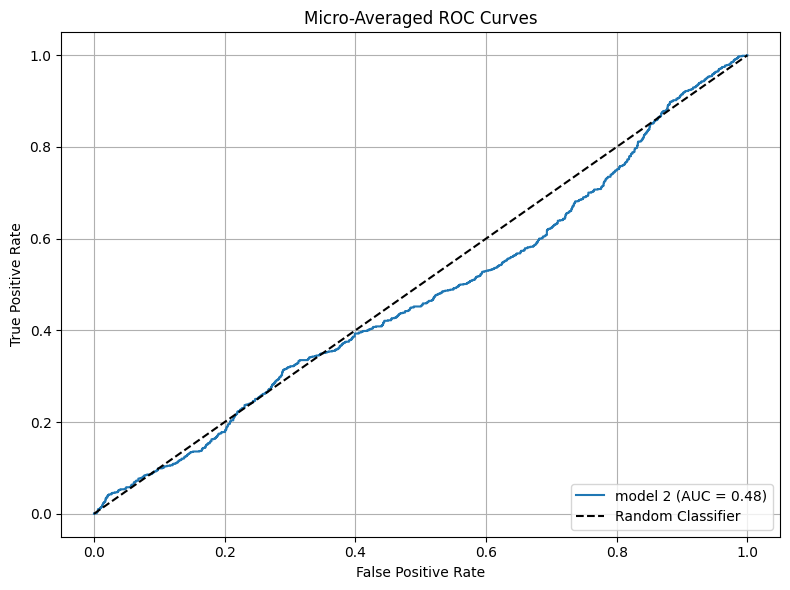

In [23]:
data_loader_to_use =  test_loader
if data_loader_to_use is None:
    raise ValueError("No data available for evaluation.")

all_reports = evaluate_and_compare_models(
    model=model2,
    name="model 2",
    data_loader=data_loader_to_use,
    device=device,
    num_classes=3
)


In [25]:
def objective(trial):
    # ─── Hyperparameter suggestions ───
    lr           = trial.suggest_loguniform("learning_rate",   1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay",   1e-6, 1e-2)
    dropout      = trial.suggest_float("dropout_rate",        0.2, 0.7)
    base_dim     = trial.suggest_categorical("base_dim",   [64, 96, 128])
    n_blocks     = trial.suggest_int("n_blocks",             1, 3)
    batch_size   = trial.suggest_categorical("batch_size", [8, 16, 32])

    # ─── Build model with sampled capacity + dropout ───
    model = EEGConvNeXt_1D(
        n_channels=actual_n_channels,
        n_timesteps=actual_n_timesteps,
        num_classes=num_classes_actual,
        depths=[n_blocks, n_blocks, n_blocks*2, n_blocks],
        dims=[base_dim, base_dim*2, base_dim*4, base_dim*8],
        dropout_rate=dropout
    ).to(device)

    model.apply(init_weights)


    # ─── Create loaders with sampled batch size ───
    train_loader = DataLoader(
        TensorDataset(X_train_tensor, y_train_tensor),
        batch_size=batch_size, shuffle=True
    )
    val_loader = DataLoader(
        TensorDataset(X_val_tensor, y_val_tensor),
        batch_size=batch_size, shuffle=False
    )

    # ─── Optimizer + weight decay ───
    optimizer = optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

    # ─── Quick training ───
    train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=20, device=device)

    # ─── Validation accuracy ───
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv, yv = Xv.to(device), yv.to(device)
            preds = model(Xv).argmax(dim=1)
            correct += (preds == yv).sum().item()
            total   += yv.size(0)
    return correct / total


In [ ]:
# Optionally use a pruner to stop bad trials early:
pruner = optuna.pruners.MedianPruner()

study = optuna.create_study(
    direction="maximize",
    study_name="eeg_hpo",
    pruner=pruner
)

study.optimize(objective, n_trials=30, timeout=9600)  # e.g. 30 trials or 1h max

print(f"Best Val Acc: {study.best_value:.4f}")
print("Best hyperparams:")
for key, val in study.best_params.items():
    print(f"  {key}: {val}")


In [ ]:
best = study.best_params

final_model = EEGConvNeXt_1D(
    n_channels=actual_n_channels,
    n_timesteps=actual_n_timesteps,
    num_classes=num_classes_actual,
    depths=[best["n_blocks"]]*2 + [best["n_blocks"]*2]*1 + [best["n_blocks"]],  # or however you want to map them
    dims=[best["base_dim"], best["base_dim"]*2, best["base_dim"]*4, best["base_dim"]*8],
    dropout_rate=best["dropout_rate"]
).to(device)

opt_final = optim.Adam(final_model.parameters(), lr=best["learning_rate"])
crit_final = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Train fully
train_model(final_model, train_loader, val_loader, crit_final, opt_final, num_epochs=50, device=device)

# Evaluate on test set as before...
evaluate_and_compare_models(final_model, "Final Model", test_loader, device, num_classes_actual)
